### Загрузка библиотек

In [1005]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    LearningCurveDisplay,
    ShuffleSplit,
    KFold,
)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

### Загрузка данных

In [1006]:
data = pd.read_excel('online_retail_II.xlsx')
data.head()
data.info()
data.shape
data.isna().sum()
data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

(417534, 8)

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

### Предобработка

In [1007]:
data = data[data['Customer ID'].notnull()]
data.isna().sum()
numeric = data.groupby('Customer ID', group_keys=False).sum(numeric_only=True)
numeric = numeric.reset_index()
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date
features = data[['Customer ID', 'Country']]
features_clean = features.drop_duplicates(subset = 'Customer ID')
features_clean = features_clean.reset_index(drop = True)
data_new = features_clean.merge(numeric, on = 'Customer ID')
dates = data[['Customer ID', 'InvoiceDate']]
dates = dates.drop_duplicates()
dates['LastPurchaseDate'] = dates.groupby('Customer ID')['InvoiceDate'].transform('max')
dates['DaysUntilPurchase'] = (dates['LastPurchaseDate'].max() - dates['LastPurchaseDate']).dt.days
dates = dates.groupby('Customer ID').apply(lambda x: x)
dates = dates.drop_duplicates(subset = ['Customer ID', 'DaysUntilPurchase'])
data_final = data_new.merge(dates, on = ['Customer ID'])

C:\Users\Дарья\AppData\Local\Temp\ipykernel_19648\3600864799.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dates = dates.groupby('Customer ID').apply(lambda x: x)


In [1008]:

#data['StockCode'] = data['StockCode'].astype('str')
#numeric
#numeric = data.groupby(['InvoiceDate', 'Customer ID'], group_keys=False).sum(numeric_only=True)
#numeric['Total Price'] = numeric['Quantity'] * numeric['Price']
#numeric = numeric.drop('Price', axis = 1)
#numeric = numeric.reset_index()
numeric

,Customer ID,Quantity,Price
0,12346.0,52,578.36
1,12347.0,828,162.95
2,12348.0,373,14.39
3,12349.0,988,899.49
4,12351.0,261,49.46
...,...,...,...
4378,18283.0,336,498.82
4379,18284.0,493,116.09
4380,18285.0,145,100.20
4381,18286.0,592,306.55


In [1009]:

features_clean

,Customer ID,Country
0,13085.0,United Kingdom
1,13078.0,United Kingdom
2,15362.0,United Kingdom
3,18102.0,United Kingdom
4,12682.0,France
...,...,...
4378,18269.0,United Kingdom
4379,13270.0,United Kingdom
4380,12942.0,United Kingdom
4381,13369.0,United Kingdom


In [1010]:

data_new

,Customer ID,Country,Quantity,Price
0,13085.0,United Kingdom,727,1041.17
1,13078.0,United Kingdom,6466,1876.62
2,15362.0,United Kingdom,368,144.48
3,18102.0,United Kingdom,122988,6408.17
4,12682.0,France,5434,1793.30
...,...,...,...,...
4378,18269.0,United Kingdom,76,22.15
4379,13270.0,United Kingdom,200,2.95
4380,12942.0,United Kingdom,69,87.55
4381,13369.0,United Kingdom,149,91.62


In [1011]:

data_final

,Customer ID,Country,Quantity,Price,InvoiceDate,LastPurchaseDate,DaysUntilPurchase
0,13085.0,United Kingdom,727,1041.17,2009-12-01,2010-10-15,55
1,13078.0,United Kingdom,6466,1876.62,2009-12-01,2010-12-08,1
2,15362.0,United Kingdom,368,144.48,2009-12-01,2010-09-17,83
3,18102.0,United Kingdom,122988,6408.17,2009-12-01,2010-12-09,0
4,12682.0,France,5434,1793.30,2009-12-01,2010-12-09,0
...,...,...,...,...,...,...,...
4378,18269.0,United Kingdom,76,22.15,2010-12-08,2010-12-08,1
4379,13270.0,United Kingdom,200,2.95,2010-12-08,2010-12-08,1
4380,12942.0,United Kingdom,69,87.55,2010-12-09,2010-12-09,0
4381,13369.0,United Kingdom,149,91.62,2010-12-09,2010-12-09,0


### Построение моделей

In [1012]:
X = data_final.drop(['DaysUntilPurchase', 'LastPurchaseDate'], axis=1)
y = data_final['DaysUntilPurchase']

scal = StandardScaler()
enc = OrdinalEncoder()
X = enc.fit_transform(X)
X = scal.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Absolute Error: 57.25138847422962
Mean Squared Error: 5272.259175539838
R-squared: 0.49588030452834353


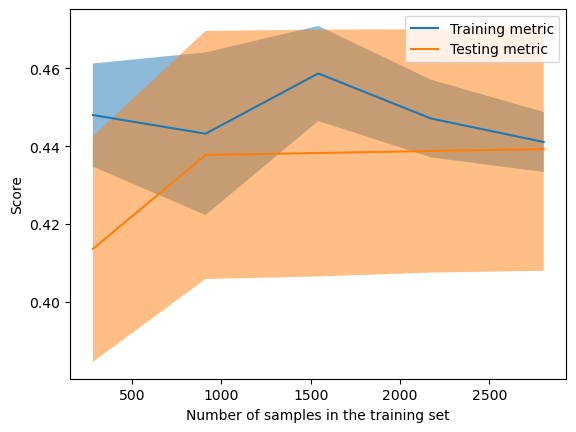

In [1013]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

LearningCurveDisplay.from_estimator(lin_reg, X_train, y_train, cv=5, score_type="both")
plt.show()

In [1014]:
lasso = LassoCV()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

ridge = RidgeCV()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Absolute Error: 57.254172339837474
Mean Squared Error: 5273.222624658334
R-squared: 0.4957881820320762
Mean Absolute Error: 57.2685091017074
Mean Squared Error: 5276.4131639453135
R-squared: 0.4954831109723672


Mean Absolute Error: 44.62901603058555
Mean Squared Error: 4111.0260837315
R-squared: 0.6069143893718847


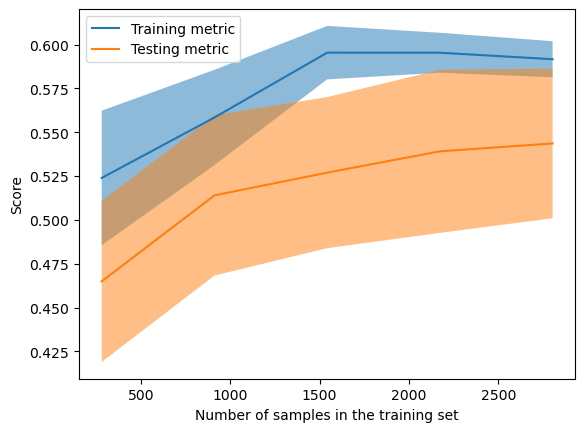

In [1015]:
param_grid = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 12, 17, 19, 20],
}
knn = KNeighborsRegressor()
gs_knn = GridSearchCV(knn, param_grid, cv=3)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

knn = KNeighborsRegressor(n_neighbors=17)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

LearningCurveDisplay.from_estimator(knn, X_train, y_train, cv=5, score_type="both")
plt.show()

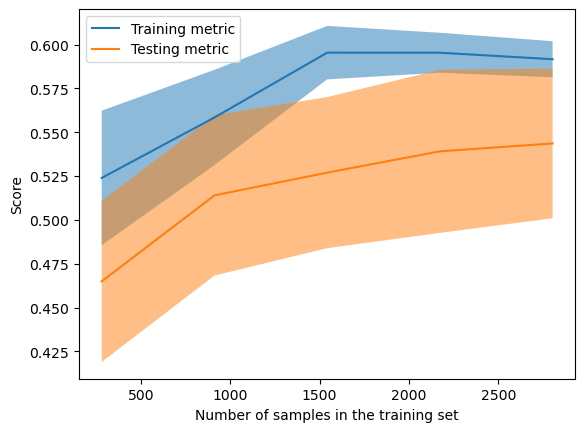

In [ ]:
param_grid = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_leaf_nodes": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90],
}
forest = DecisionTreeRegressor(random_state=42)
gs_forest = GridSearchCV(forest, param_grid, cv=3)
gs_forest.fit(X_train, y_train)
gs_forest.best_params_

In [1016]:


forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)



Mean Absolute Error: 42.497251995438994
Mean Squared Error: 4113.720783466363
R-squared: 0.6066567291991776


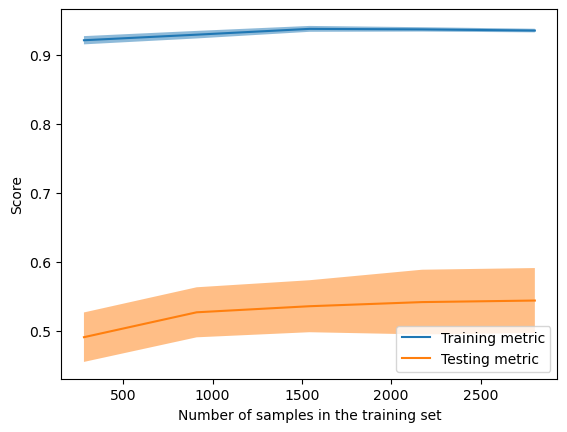

In [1018]:
LearningCurveDisplay.from_estimator(forest, X_train, y_train, cv=5, score_type="both")
plt.show()

Mean Absolute Error: 42.99154202420798
Mean Squared Error: 3895.1415784813576
R-squared: 0.6275567036853893


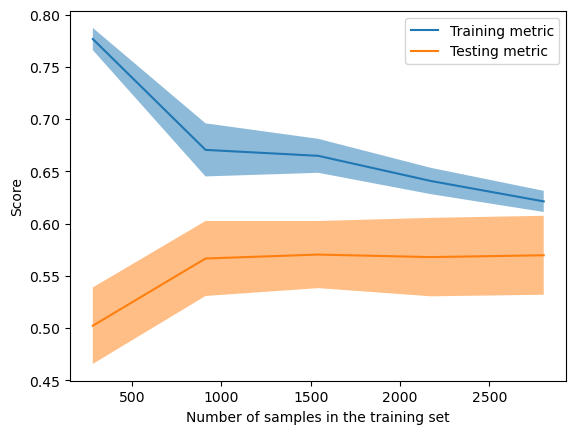

In [1021]:
param_grid = {
    "splitter": ["best", "random"],
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_leaf_nodes": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90],
}
tree = DecisionTreeRegressor(random_state=42)
gs_tree = GridSearchCV(tree, param_grid, cv=3)
gs_tree.fit(X_train, y_train)
gs_tree.best_params_

{'max_depth': 9,
 'max_leaf_nodes': 40,
 'min_samples_leaf': 4,
 'splitter': 'random'}

Mean Absolute Error: 46.757914741681844
Mean Squared Error: 4375.638214876874
R-squared: 0.5816128663378899


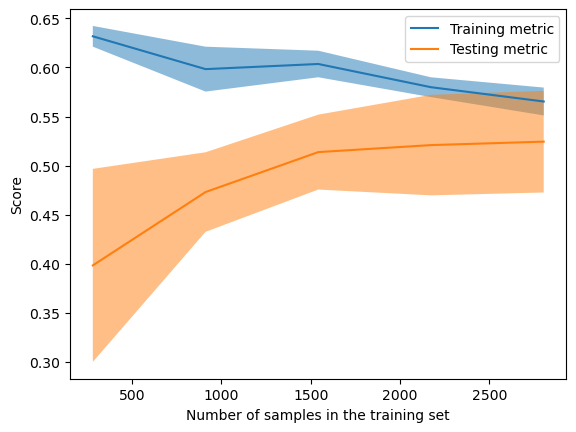

In [1022]:
tree = DecisionTreeRegressor(max_depth = 9, max_leaf_nodes = 40, min_samples_leaf = 4, splitter = 'random')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

LearningCurveDisplay.from_estimator(tree, X_train, y_train, cv=5, score_type="both")
plt.show()

Mean Absolute Error: 43.640123592259876
Mean Squared Error: 4077.090578161681
R-squared: 0.6101592140597345


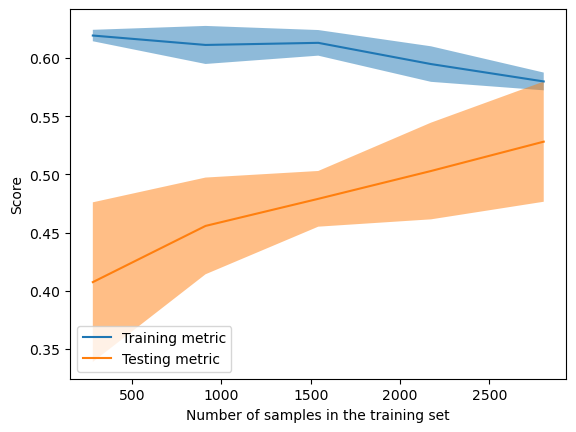

In [963]:
param_grid = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}
xgb = xgboost.XGBRegressor()
gs_xgb = GridSearchCV(xgb, param_grid, cv=3)
gs_xgb.fit(X_train, y_train)
gs_xgb.best_params_



{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60}

Mean Absolute Error: 46.16326125833113
Mean Squared Error: 4790.5201764478725
R-squared: 0.5419429333622524


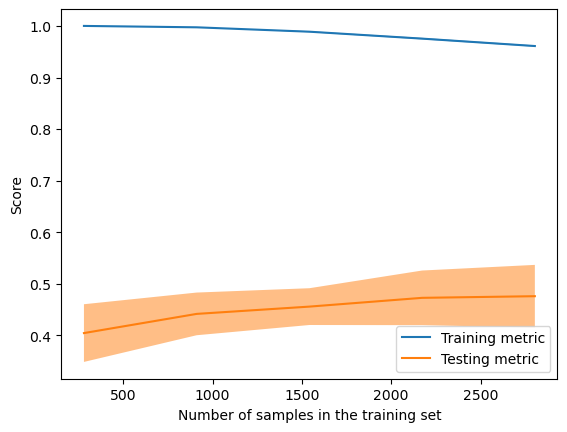

In [1023]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

LearningCurveDisplay.from_estimator(xgb, X_train, y_train, cv=5, score_type="both")
plt.show()

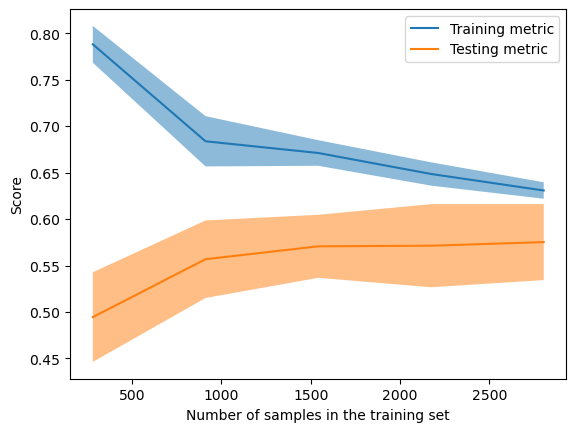